# BaBar $\sigma(e^+e^- \rightarrow \pi^+\pi^- (\gamma))$

The latest BaBar measurements are published in two papers, a PRL and a later PRD containing more detailed information. Both papers report the cross-section information in the supplemental material, in ASCII files that are identical.

* B. Aubert et al. \[BaBar Collaboration\], [Phys. Rev. Lett. 103 (2009) 231801](https://doi.org/10.1103/PhysRevLett.103.231801), [inspirehep](http://inspirehep.net/record/829441),<br />
"Precise measurement of the e+ e- ---> pi+ pi- (gamma) cross section with the Initial State Radiation method at BABAR"

* J. P. Lees et al. \[BaBar Collaboration\], [Phys. Rev. D 86 (2012) 032013](https://doi.org/10.1103/PhysRevD.86.032013), [inspirehep](http://inspirehep.net/record/1114155),<br />
"Precise Measurement of the e+e− → π+π−(γ)e+e−→π+π−(γ) Cross Section with the Initial-State Radiation Method at BABAR"
  * [supplemental material folder](http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/)
    * [BABAR_ISR2pi_EPAPS.txt](http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/BABAR_ISR2pi_EPAPS.txt)

The data report the "**bare cross section including FSR**" in nb, and in detail:
* the cross-section and its total undertainty in variable-width bins of energy
* the per-mil relative systematic uncertainty (per energy bin, 100% correlated on all bins)
* the statistical correlation between any two bins of cross-section

In the following the data are used to show a few plots.

<!-- TEASER_END -->

In [43]:
using DataFrames
## using DataFramesMeta

using TextParse
using CSV

using FileIO

## using Plots
using StatsPlots
using Measures

using LaTeXStrings
using Query

In [44]:
Plots.default(
  size = (700, 400),
  framestyle = :box,
  tickdirection = :out,
  top_margin = 4pt,
  bottom_margin = 4pt,
  left_margin = 4pt,
  right_margin = 10pt,
  ## color = 1,
  mswidth = 1,
  mscolor = :auto,
  markershape = :auto,
  legend = true,
  titlefontsize = 12,
  fillalpha = 0.50,
)

Plots.pyplot(fmt=:svg)

plots_cpal = palette(:auto)
plots_mshapes = (
  :circle, :rect, :utriangle, :dtriangle, :rtriangle, :ltriangle, :star5, :diamond,
  :hexagon, :cross, :xcross, :pentagon, :star4
)

##
## savefig() without side-effect of printing pending figures
##

function savefigsilent(plt::Plots.Plot{Plots.PyPlotBackend}, fn::AbstractString)
  ##--- brutally close all pending figures prepared for display according to PyPlot
  for manager in PyPlot.Gcf."get_all_fig_managers"()
    f = manager."canvas"."figure"
    if f.number ∉ PyPlot.withfig_fignums
      ##--- close only figures not suspended for further handling
      close(f.number)
    end
  end
  savefig(plt, fn)
end
savefigsilent(fn::AbstractString) = savefigsilent(current(), fn::AbstractString)

##
## savefig() in dedicated folder
##

mysavefig(plt::Plots.Plot{Plots.PyPlotBackend}, fn::AbstractString) = 
  savefigsilent(plt, joinpath(myfolder, fn))
mysavefig(fn::AbstractString) = savefigsilent(joinpath(myfolder, fn))

nothing

In [45]:
##
## defs and functions
##

In [46]:
##
## readlines_enh() enhanced readlines() function
## - <skipto> begin reading from indicated line
## - <limit> number of lines to read
##
function readlines_enh(filename::AbstractString; skipto=1, limit=Inf, kw...)
  open(filename) do f
    readlines_enh(f, skipto=skipto, limit=limit; kw...)
  end
end
##
## readlines_enh() from file stream
##
readlines_enh(s=stdin; skipto=1, limit=Inf, kw...) =
  collect(Iterators.take(Iterators.drop(eachline(s; kw...), skipto-1), limit))
nothing

In [47]:
##
## get extrema and extend them by desired amount
##
function extrema_ext(A, ext)
  a, b = extrema(A)
  marg = (b-a)*ext
  a-marg, b+marg
end

extrema_ext (generic function with 1 method)

In [48]:
##
## code
##

In [49]:
##
## download BaBar Phys. Rev. D 86 (2012) 032013 suppl. mat.
##
tmpfile = download("http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/BABAR_ISR2pi_EPAPS.txt")

nothing

In [50]:
##
## read cross-section val and unc of cross-section by energy bin
## - data in lines 30..366
## 
## format is
##
## E_l    E_h           val                      unc
## 2.8  : 2.9           0.009181                 0.0132598"
##
sigma_df = DataFrame!(CSV.File(
  tmpfile,
  skipto=30, limit=337, delim=' ', ignorerepeated=true,
  header=[:E_l, :colon, :E_h, :sigma_val, :sigma_unc]
))
select!(sigma_df, Not(:colon))

##--- add energy bin mid-point
transform!(sigma_df, [:E_l, :E_h] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E)

display(first(sigma_df, 4))
nothing

4×5 DataFrame
│ Row │ E_l     │ E_h     │ sigma_val │ sigma_unc │ E       │
│     │ Float64 │ Float64 │ Float64   │ Float64   │ Float64 │
├─────┼─────────┼─────────┼───────────┼───────────┼─────────┤
│ 1   │ 0.3     │ 0.31    │ 25.4904   │ 2.69943   │ 0.305   │
│ 2   │ 0.31    │ 0.32    │ 35.4801   │ 2.91464   │ 0.315   │
│ 3   │ 0.32    │ 0.33    │ 45.4858   │ 3.04669   │ 0.325   │
│ 4   │ 0.33    │ 0.34    │ 51.7825   │ 3.13355   │ 0.335   │

In [51]:
##
## read cross-section systematic uncertainties
##

##
## read 1 line reporting energy intervals [E_l, E_h] for systematic contributions
## resulting DataFrame ha 1 row with 8 strings of rormat E_l_i,E_h_i
##
tmp_df = DataFrame!(CSV.File(
  tmpfile,
  skipto=388, limit=1, delim=' ', ignorerepeated=true,
  header=false
))
##
## convert first row of tmp_df into a vector and then a newline-separated stream
## and then read the stream as a DF with two columns E_l, E_h and 8 rows
##
sigma_syst_df = DataFrame!(CSV.File(IOBuffer(join(Vector(tmp_df[1, :]), "\n")), header=[:E_l, :E_h], delim='-'))

##
## read line with systematic unc's for the just read energy intervals, 8 numbers in parenthesis
##
line_tmp = readlines_enh(tmpfile, skipto=401, limit=1)
line_tmp = strip(replace(line_tmp[1],  r"\(([^\)]*)\)" => s"\1"))
##--- read numeric values into DF with 1 row and 8 columns
tmp_df = DataFrame!(CSV.File(IOBuffer(convert(String, line_tmp)),
    delim=' ', ignorerepeated=true, header=false))
##--- remove columns with no data
## tmp_df = tmp_df[!, eltype.(eachcol(tmp_df)) .!= Missing]
##--- add total systematic uncertainties to DF of syst. uncert.
sigma_syst_df.sigma_syst_unc_permille = Vector(tmp_df[1, :])
##--- add to dataframe energy bins mid point
transform!(sigma_syst_df, [:E_l, :E_h] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E)
display(first(sigma_syst_df, 4))
nothing

4×4 DataFrame
│ Row │ E_l     │ E_h     │ sigma_syst_unc_permille │ E       │
│     │ Float64 │ Float64 │ Float64                 │ Float64 │
├─────┼─────────┼─────────┼─────────────────────────┼─────────┤
│ 1   │ 0.3     │ 0.4     │ 13.8                    │ 0.35    │
│ 2   │ 0.4     │ 0.5     │ 8.1                     │ 0.45    │
│ 3   │ 0.5     │ 0.6     │ 10.2                    │ 0.55    │
│ 4   │ 0.6     │ 0.9     │ 5.0                     │ 0.75    │

In [52]:
##
## return first index for which x is in the range of lower[row]..upper[row]
##
function find_E_bin(x::AbstractFloat, lower::AbstractArray, upper::AbstractArray)
  nrow = length(lower)
  nrow == length(upper) || throw("lower / upper size mismatch")
  for row in 1:nrow
    if (x >= lower[row] && x <= upper[row])
      return row
    end
  end
  return nothing
end

find_E_bin (generic function with 1 method)

In [53]:
##
## return cross-section value from energy E
## by finding the appropriate energy bin
##
function sigma_val(E)
  E_bin = find_E_bin(E, sigma_df.E_l, sigma_df.E_h)
  ifelse(isnothing(E_bin), missing, sigma_df.sigma_val[E_bin])
end

##
## get syst unc for given energy
## using paper definition
##
function sigma_syst_unc(E)
  E_bin = find_E_bin(E, sigma_syst_df.E_l, sigma_syst_df.E_h)
  val = sigma_val(E)
  if isnothing(E_bin)
    missing
  else
    sigma_val(E) * sigma_syst_df[E_bin, :sigma_syst_unc_permille] / float(1000)
  end
end

##
## compute systematic covariance using the systematics per energy bins
## systematics are "100% correlated in all energy bins"
##
function sigma_syst_cov(E_x, E_y)
  sigma_syst_unc(E_x) * sigma_syst_unc(E_y)
end

##
## systematics covariance is 100% wherever it is defined
##
function sigma_syst_corr(E_x, E_y)
  if ismissing(sigma_syst_unc(E_x) * sigma_syst_unc(E_y))
    missing
  else
    float(1)
  end
end

sigma_syst_corr (generic function with 1 method)

In [54]:
##
## the txt file lists the statistical covariance row by row using the energy bins
## defined for reporting the cross section
## there are N energy bins, the covariance is a matrix with rows and colums
## the first values are for columns 1:N and row=1
## the next values are for columns 1:N and row=2 and so on
##
if true
  ##
  ## get statistical covariance
  ##
  sigma_stat_df = DataFrame!(CSV.File(
    tmpfile,
    skipto=406, limit=337*337, delim=' ', ignorerepeated=true,
    header=["sigma_stat_cov"], use_mmap=false
  )) 
else
  ##
  ## alternative way of getting stat. cov.
  ##
  sigma_stat_df = DataFrame(sigma_stat_cov = parse.(Float64, strip.(
      readlines_enh(tmpfile, skipto=407, limit=337*337))))
end

nothing

In [55]:
##
## build a dataframe where for each covariance coefficient we have:
## - column central energy, low edge of energy bin, high edge of energy bin
## - same as above for the row
## this dataframe is used for doing a contour plot
##

sigma_stat_df.E_l_r = repeat(sigma_df.E_l, inner=nrow(sigma_df))
sigma_stat_df.E_h_r = repeat(sigma_df.E_h, inner=nrow(sigma_df))
sigma_stat_df.E_l_c = repeat(sigma_df.E_l, outer=nrow(sigma_df))
sigma_stat_df.E_h_c = repeat(sigma_df.E_h, outer=nrow(sigma_df))
transform!(sigma_stat_df, [:E_l_r, :E_h_r] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E_r)
transform!(sigma_stat_df, [:E_l_c, :E_h_c] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E_c)

display(first(sigma_stat_df, 4))
nothing

4×7 DataFrame. Omitted printing of 1 columns
│ Row │ sigma_stat_cov │ E_l_r   │ E_h_r   │ E_l_c   │ E_h_c   │ E_r     │
│     │ Float64        │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 7.16412        │ 0.3     │ 0.31    │ 0.3     │ 0.31    │ 0.305   │
│ 2   │ 0.811213       │ 0.3     │ 0.31    │ 0.31    │ 0.32    │ 0.305   │
│ 3   │ 0.0292493      │ 0.3     │ 0.31    │ 0.32    │ 0.33    │ 0.305   │
│ 4   │ 0.216073       │ 0.3     │ 0.31    │ 0.33    │ 0.34    │ 0.305   │

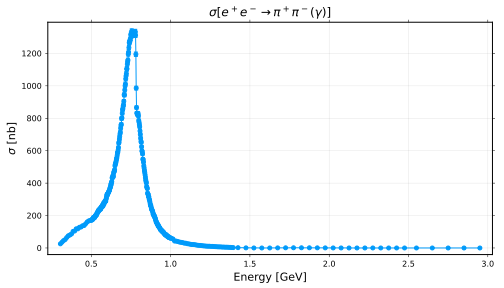

In [56]:
##
## plot cross-section vs. energy (stat. unc. only)
##
curpl = @df sigma_df plot(
  :E,
  :sigma_val,
  yerror = :sigma_unc,
  title = L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$",
  xlabel = "Energy [GeV]",
  ylabel = L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false
)
## mysavefig(curpl, "curpl.pdf")
## display(curpl)

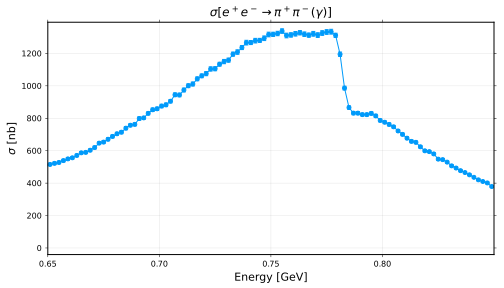

In [57]:
##
## plot cross-section vs. energy around rho / omega interference
##
curpl = @df sigma_df plot(
  :E,
  :sigma_val,
  yerror=:sigma_unc,
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false,
  xlim=(0.65,0.85)
)
## mysavefig(curpl, "curpl.pdf")
## display(curpl)

In [74]:
##
## plot statistical covariance surface plot
##
curpl = @df sigma_stat_df surface(
  :E_c,
  :E_r,
  :sigma_stat_cov,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  ## zlabel="σ covariance",
  ## camera=(0, 90),
  clims = (
    minimum(:sigma_stat_cov)-0.2*(maximum(:sigma_stat_cov)-minimum(:sigma_stat_cov)),
    maximum(:sigma_stat_cov)+0.2*(maximum(:sigma_stat_cov)-minimum(:sigma_stat_cov))
  )
)

##--- don't show plot
nothing

In [63]:
##
## functions for producing contour plots of stat covariance
##

##
## get covariance as function of two energies
##
## energy bins are the same for sigma values / uncertainties and covariance
## stat. cov. dataframe lists covariance coefficients by row and column
##
function sigma_stat_cov(E_x, E_y)
  E_bin_x = find_E_bin(E_x, sigma_df.E_l, sigma_df.E_h)
  E_bin_y = find_E_bin(E_y, sigma_df.E_l, sigma_df.E_h)
  if (E_bin_x == nothing || E_bin_y == nothing)
    return missing
  end
  ##
  ## interpret cov values vector as matrix with n rows and n columns
  ## return appropriate cov value for required row and column
  ##
  reshape(sigma_stat_df.sigma_stat_cov, (nrow(sigma_df), nrow(sigma_df)))[E_bin_x, E_bin_y]
end

sigma_stat_cov_clims = @df sigma_df identity( extrema_ext((sigma_stat_cov(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )

##--- get correlation as function of two energies
function sigma_stat_corr(E_x, E_y)
  sigma_stat_cov(E_x, E_y) / sqrt(sigma_stat_cov(E_x, E_x) * sigma_stat_cov(E_y, E_y))
end

sigma_stat_corr_clims = @df sigma_df identity( extrema_ext((sigma_stat_corr(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )

nothing

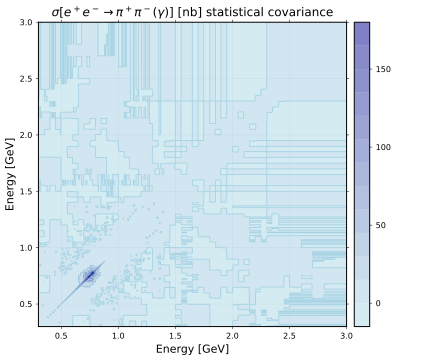

In [64]:
##
## plot statistical covariance contour plot
##
curpl = @df sigma_df contourf(
  range(extrema(vcat(:E_l, :E_h))..., length=500),
  range(extrema(vcat(:E_l, :E_h))..., length=500),
  sigma_stat_cov,
  ## clims = sigma_stat_cov_clims,
  color = :blues,
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$ [nb] statistical covariance",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(600, 500)
)

In [65]:
##
## plot statistical correlation contour plot
##
curpl = @df sigma_df contourf(
  range(extrema(vcat(:E_l, :E_h))..., length=500),
  range(extrema(vcat(:E_l, :E_h))..., length=500),
  sigma_stat_corr,
  ## clims = sigma_stat_corr_clims,
  color = :blues,
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$ [nb] statistical correlation",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(600, 500)
)

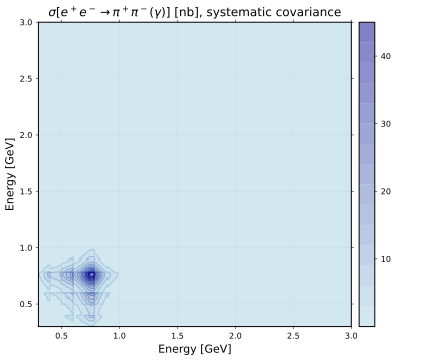

In [66]:
##
## plot systematic covariance contour plot
## there is no systematic covariance, just diagonal systematic uncertainties
##

sigma_syst_cov_clims = @df sigma_syst_df identity( extrema_ext((sigma_syst_cov(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )
## println("range of covariance values:", cov_clims)
## println("note: color legend is not accurate, does not match custom color limits ", syst_cov_clims)

##
## plot
##
curpl = @df sigma_syst_df contourf(
  range(extrema(vcat(:E_l, :E_h))..., length=500),
  range(extrema(vcat(:E_l, :E_h))..., length=500),
  (x, y) -> sigma_syst_cov(x, y),
  ## (x, y) -> log(syst_cov(x, y)),
  ## clims = sigma_syst_cov_clims,
  color = :blues,
  ## levels = exp.(range(log.(extrema(sigma_syst_df.E))..., length=10)),
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$ [nb], systematic covariance",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(600, 500),
)